## Mood analysis in Barcelona

In [5]:
# Imports

from classifier import *
clf = SentimentClassifier()

import pandas as pd
import sklearn
import missingno as msno
import math
import csv
from keplergl import KeplerGl
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# Tokenizing and removing stopwords functions.

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import unicodedata
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def clean_en_text(quote):
  words = quote.split()
  words = [word.lower() for word in words if (word.isalpha() and word not in en_stop_words and word != "\n" and word != "rt")]
  return (" ").join(words)

def clean_es_text(quote):
  words = quote.split()
  words = [word.lower() for word in words if (word.isalpha() and word not in es_stop_words and word != "\n" and word != "rt")]
  return (" ").join(words)


[nltk_data] Downloading package punkt to /home/irene/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/irene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# ENGLISH SENTIMENT ANALYSIS with VADER:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score
    #print("{:-<40} {}".format(sentence, str(score)))
  

# Getting only the negative score
def negative_score(text):
    negative_value = analyser.polarity_scores(text)['neg']
    return negative_value

# Getting only the neutral score
def neutral_score(text):
    neutral_value = analyser.polarity_scores(text)['neu']
    return neutral_value

# Getting only the positive score
def positive_score(text):
    positive_value = analyser.polarity_scores(text)['pos']
    return positive_value
   

# Assigning a value according to sentiment
def sentiment_classifier(text):
    """
    English sentiment model gives three diferent scores between 0 and 1, for negative, positive and neutral comments.
    We decided to compare "positive" and "negative" scores and, in case they were equal, then consider it as "neutral".
    """
    VADER_sent_en = []
    sentiment_scores = {"neg":0, "pos":1, "neu":2}
    for item in text:
        if negative_score(item) > positive_score(item):
            VADER_sent_en.append(sentiment_scores["neg"])
        elif negative_score(item) < positive_score(item):
            VADER_sent_en.append(sentiment_scores["pos"])
        else:
            VADER_sent_en.append(sentiment_scores["neu"])
    
    return VADER_sent_en


In [8]:
# SPANISH SENTIMENT ANALISYS with SENTY:

from classifier import *
clf = SentimentClassifier()


def senty_classifier_es(text):
    """
    Spanish sentiment model gives a score between 0 and 1, Being 0 the most "negative" score and 1 the most "positive" score.
    We decided to take all scores between 0.4 and 0.6 as to be "neutral".
    """
    SENTY_sent_es = []
    sentiment_scores = {"neg":0, "pos":1, "neu":2}
    max_neg_score = 0.4
    min_pos_score = 0.6
    if type(text)!=float:
        if clf.predict(text) < max_neg_score:
            SENTY_sent_es.append(sentiment_scores["neg"])
        elif clf.predict(text) > min_pos_score:
            SENTY_sent_es.append(sentiment_scores["pos"])
        else:
            SENTY_sent_es.append(sentiment_scores["neu"])
    else:
        SENTY_sent_es.append(sentiment_scores["neu"])
    
    return SENTY_sent_es


In [80]:
# Importing the datasets:

path_to_file0 = './data/coronavirus_data.csv'
data = pd.read_csv(path_to_file0, encoding= "utf-8")

# Load Barcelona neighborhood coordinates:
barris = "./data/bcn-barris.geojson"
map_data = gpd.read_file(barris)
map_data.head(2)

,ID_ANNEX,ANNEXDESCR,ID_TEMA,TEMA_DESCR,ID_CONJUNT,CONJ_DESCR,ID_SUBCONJ,SCONJ_DESC,ID_ELEMENT,ELEM_DESCR,...,ESTIL_ID,ESTIL_QGIS,VALOR1QGIS,VALOR2QGIS,COL_FARCIT,FCOL_DESCR,FHEX_COLOR,COL_DESCR,HEX_COLOR7,geometry
0,01,Grup - I,0104,Unitats Administratives,010413,Barris,01041301,Barri,0104130101,Límit de barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#73A88F,"POLYGON ((2.16471 41.38593, 2.16936 41.38554, ..."
1,01,Grup - I,0104,Unitats Administratives,010413,Barris,01041301,Barri,0104130101,Límit de barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#73A88F,"POLYGON ((2.17701 41.38525, 2.17873 41.38396, ..."


In [81]:
print(data.shape)
print(data.columns)
data.head(2)

(475, 6)
Index(['location', 'followers', 'comments', 'coordinates', 'language',
       'geometry'],
      dtype='object')


,location,followers,comments,coordinates,language,geometry
0,NaN,243,RT @StevePieczenik: #Dominion \n#DominionVotin...,NaN,und,NaN
1,NaN,114,RT @StevePieczenik: #Dominion \n#DominionVotin...,NaN,und,NaN


In [82]:
print(data["language"].value_counts())


en     227
es     138
ca      79
und     10
tr       5
in       4
pt       2
de       2
sv       2
ht       1
pl       1
fr       1
nl       1
ro       1
it       1
Name: language, dtype: int64


### We will focus on English and Spanish tweets since we have more of them.

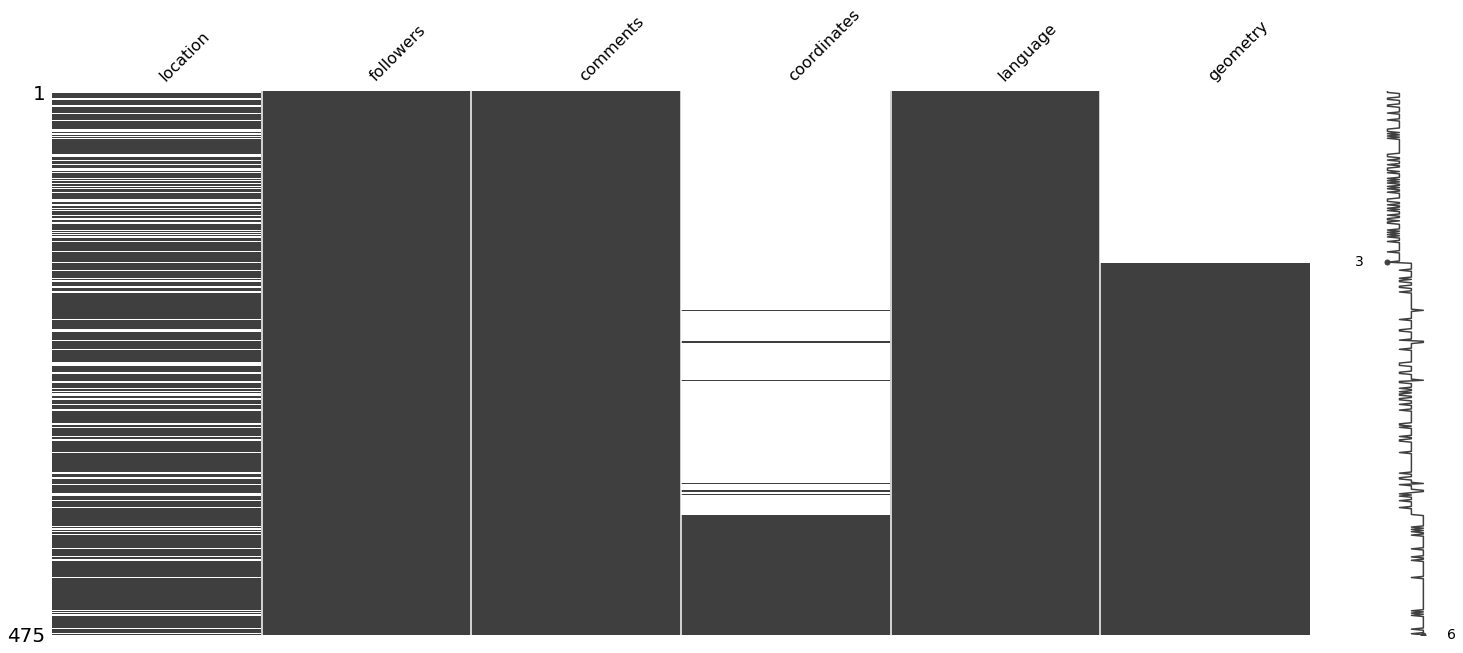

In [83]:
msno.matrix(data);

In [84]:
data[~data.coordinates.isnull()]

,location,followers,comments,coordinates,language,geometry
191,Catalunya,184,Tant enyorada... en el Camp d'en Grassot i Gra...,"[41.40468875, 2.16672453]",ca,"[[[2.052477, 41.317048], [2.052477, 41.468266]..."
218,"London, United Kingdom",138031,#Germany’s confirmed coronavirus cases increas...,"[51.50538967, -0.12485951]",en,"[[[-0.187894, 51.483718], [-0.187894, 51.51646..."
219,"Barcelona, Espanya",445,"≈40,9 km (intensitat 3/10, superfície 0.1/10)\...","[41.383333, 2.183333]",ca,"[[[2.052477, 41.317048], [2.052477, 41.468266]..."
252,"Red Sea, Egypt",1867,#insta #suez #happy #vacation #coursetraining ...,"[29.9722, 32.5491]",en,"[[[31.860555, 28.965008], [31.860555, 30.30367..."
342,Barcelona,267,Acaba de publicar una foto en Centre Cívic Sag...,"[41.40589451, 2.1765811]",ca,"[[[2.052477, 41.317048], [2.052477, 41.468266]..."
...,...,...,...,...,...,...
470,BARCELONA,60,"Barcelona, pásalo ⭐ ⭐ ⭐ ⭐ ⭐ ⭐ @bcnlegendz cuan...","[41.3684, 2.1162]",es,"[[[2.086323, 41.336062], [2.086323, 41.380548]..."
471,"Timmins, Ontario",1702,"Province reports 1,708 new, confirmed COVID-19...","[48.47593351, -81.32806152]",en,"[[[-81.729849, 48.2768], [-81.729849, 48.71218..."
472,Sant Cugat del Vallés,244,#hoy a portarse bien! #sardinas #comida #food ...,"[41.3894, 2.1683]",es,"[[[2.052477, 41.317048], [2.052477, 41.468266]..."
473,NaN,138,Los arcos de Ca L’Alemany #calalemany en Ca l'...,"[41.459335, 2.232254]",ca,"[[[2.211092, 41.42594], [2.211092, 41.492681],..."


In [86]:
d = data.copy()

for i, comm in enumerate(d["language"]):
    if d["language"][i] == "en":
        d["comments"][i] = clean_en_text(d["comments"][i])
    elif d["language"][i] == "es":
        d["comments"][i] = clean_es_text(d["comments"][i])
    elif d["language"][i] == "ca":
        d["comments"][i] = clean_es_text(d["comments"][i])

d.tail()

,location,followers,comments,coordinates,language,geometry
470,BARCELONA,60,pásalo cierren,"[41.3684, 2.1162]",es,"[[[2.086323, 41.336062], [2.086323, 41.380548]..."
471,"Timmins, Ontario",1702,province reports confirmed cases today,"[48.47593351, -81.32806152]",en,"[[[-81.729849, 48.2768], [-81.729849, 48.71218..."
472,Sant Cugat del Vallés,244,portarse,"[41.3894, 2.1683]",es,"[[[2.052477, 41.317048], [2.052477, 41.468266]..."
473,NaN,138,los arcos ca ca,"[41.459335, 2.232254]",ca,"[[[2.211092, 41.42594], [2.211092, 41.492681],..."
474,"Torelló/Sant Cugat , Barcelona",2972,just posted photo sant cugat vallès,"[41.4706, 2.0852]",ca,"[[[1.999829, 41.415036], [1.999829, 41.519488]..."


In [99]:
## CHECKING IF THE SPANISH SENTIMENT CLASSIFIER WORKS FOR CATALAN:
# print(d["comments"][27], senty_classifier_es(d["comments"][27]))
# d[d["language"] == "ca"]
## It does not perfectly but accurate enough.

In [100]:
# Filtering by language:

data = d.copy()
data["sentiment"] = None

for i, comm in enumerate(data["language"]):
    if data["language"][i] == "en":
        if max(sentiment_analyzer_scores(data["comments"][i]), key=sentiment_analyzer_scores(data["comments"][i]).get) == "compound":  # To get the key of the max value of a dictionary.
            data["sentiment"][i] = 1 # Positive comments.
        elif sentiment_analyzer_scores(data["comments"][i])["neg"] > sentiment_analyzer_scores(data["comments"][i])["neu"] and sentiment_analyzer_scores(data["comments"][i])["neg"] > sentiment_analyzer_scores(data["comments"][i])["pos"]:
            data["sentiment"][i] = 0 # Negative commnents.
        elif sentiment_analyzer_scores(data["comments"][i])["neu"] > sentiment_analyzer_scores(data["comments"][i])["neg"] and sentiment_analyzer_scores(data["comments"][i])["neu"] > sentiment_analyzer_scores(data["comments"][i])["pos"]:
            data["sentiment"][i] = 2 # Neutral comments
    elif data["language"][i] == "es":
        data["sentiment"][i] = senty_classifier_es(data["comments"][i])[0]
    elif data["language"][i] == "ca":
        data["sentiment"][i] = senty_classifier_es(data["comments"][i])[0]


geo_data_mood = data.copy()
data.tail()


,location,followers,comments,coordinates,language,geometry,sentiment
470,BARCELONA,60,pásalo cierren,"[41.3684, 2.1162]",es,"[[[2.086323, 41.336062], [2.086323, 41.380548]...",1
471,"Timmins, Ontario",1702,province reports confirmed cases today,"[48.47593351, -81.32806152]",en,"[[[-81.729849, 48.2768], [-81.729849, 48.71218...",2
472,Sant Cugat del Vallés,244,portarse,"[41.3894, 2.1683]",es,"[[[2.052477, 41.317048], [2.052477, 41.468266]...",0
473,NaN,138,los arcos ca ca,"[41.459335, 2.232254]",ca,"[[[2.211092, 41.42594], [2.211092, 41.492681],...",2
474,"Torelló/Sant Cugat , Barcelona",2972,just posted photo sant cugat vallès,"[41.4706, 2.0852]",ca,"[[[1.999829, 41.415036], [1.999829, 41.519488]...",0


In [101]:
# Converting "coordinates" data from string into Points:

for idx, geo in enumerate(geo_data_mood["coordinates"]):
    if type(geo_data_mood["coordinates"][idx]) != float:
        lat, lng = map(float, geo.strip('[]').split(','))
        geo_data_mood["coordinates"][idx] = Point(lng, lat)

In [103]:
# CHECKPOINT
# coronavirus_data = geo_data_mood.to_csv('coronavirus_geo_data_sentiment.csv', index = False)


# Importing the new dataset:

path_to_file3 = './data/coronavirus_geo_data_sentiment.csv'
data = pd.read_csv(path_to_file3, encoding= "utf-8")
data.tail()

,location,followers,comments,coordinates,language,geometry,sentiment
470,BARCELONA,60,pásalo cierren,POINT (2.1162 41.3684),es,"[[[2.086323, 41.336062], [2.086323, 41.380548]...",1.0
471,"Timmins, Ontario",1702,province reports confirmed cases today,POINT (-81.32806152000001 48.47593351),en,"[[[-81.729849, 48.2768], [-81.729849, 48.71218...",2.0
472,Sant Cugat del Vallés,244,portarse,POINT (2.1683 41.3894),es,"[[[2.052477, 41.317048], [2.052477, 41.468266]...",0.0
473,NaN,138,los arcos ca ca,POINT (2.232254 41.459335),ca,"[[[2.211092, 41.42594], [2.211092, 41.492681],...",2.0
474,"Torelló/Sant Cugat , Barcelona",2972,just posted photo sant cugat vallès,POINT (2.0852 41.4706),ca,"[[[1.999829, 41.415036], [1.999829, 41.519488]...",0.0


In [104]:
#CHECKPOINT
geo_data = data.copy()

# Converting Geometry data from strings into Polygons:

for idx, geo in enumerate(geo_data["geometry"]):
    if type(geo_data["geometry"][idx]) != float:
        geo_data["geometry"][idx] = geo_data["geometry"][idx][1:-1].replace(",", "")
        geo_data["geometry"][idx] = geo_data["geometry"][idx][1:-1].replace("]", "],")
        geo_data["geometry"][idx] = geo_data["geometry"][idx][:-1].split(",")
        coordinates = []
        for i, el in enumerate(geo_data["geometry"][idx]):
            counter = 0
            if el in geo_data["geometry"][idx][i] != "," and counter < 4:
                geo_data["geometry"][idx][i] = el.strip('[] ').replace("[", "")
                lat, lng = map(float, geo_data["geometry"][idx][i].split(" "))
                coordinates.append(Point(lat, lng))
                counter += 1
        geo_data["geometry"][idx] = Polygon(coordinates)


geo_data.tail()
                

,location,followers,comments,coordinates,language,geometry,sentiment
470,BARCELONA,60,pásalo cierren,POINT (2.1162 41.3684),es,"POLYGON ((2.086323 41.336062, 2.086323 41.3805...",1.0
471,"Timmins, Ontario",1702,province reports confirmed cases today,POINT (-81.32806152000001 48.47593351),en,"POLYGON ((-81.729849 48.2768, -81.729849 48.71...",2.0
472,Sant Cugat del Vallés,244,portarse,POINT (2.1683 41.3894),es,"POLYGON ((2.052477 41.317048, 2.052477 41.4682...",0.0
473,NaN,138,los arcos ca ca,POINT (2.232254 41.459335),ca,"POLYGON ((2.211092 41.42594, 2.211092 41.49268...",2.0
474,"Torelló/Sant Cugat , Barcelona",2972,just posted photo sant cugat vallès,POINT (2.0852 41.4706),ca,"POLYGON ((1.999829 41.415036, 1.999829 41.5194...",0.0


In [105]:
# CHECKPOINT
# bcn_mood_data = data.to_csv('mood_data.csv', index = False)

In [106]:
# Creating the map object:
kepler_map = KeplerGl(height = 800)

# Adding data:
with open('./data/mood_data.csv', 'r') as f:
    csvData = f.read()
kepler_map.add_data(data=csvData, name='coronavirus_geo_data_sentiment')
kepler_map.add_data(data=map_data, name='map_data')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [107]:
# Visualize the map
kepler_map

KeplerGl(data={'coronavirus_geo_data_sentiment': 'location,followers,comments,coordinates,language,geometry,se…

In [ ]:
#kepler_map.save_to_html(data={"BCN MOOD": csvData}, file_name="bcn_mood_map.html")